In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import tensorflow as tf

from scipy import stats
from sklearn.metrics import r2_score
from tqdm import tqdm
from tensorflow.keras.regularizers import l2
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import seaborn as sns

# Data
from seirsplus.seirsplus.models import SEIRSModel
from data.data import data_generator, wrapper_generation

# Model
from bayesflow.networks import HeteroskedasticModel, SequenceNet
from bayesflow.networks import BayesFlow
from bayesflow.losses import heteroskedastic_loss, maximum_likelihood_loss
from bayesflow.trainer import train_step

# Utils
from utils.misc import true_vs_estimated, plot_parameters_correlation, plot_ppc

%load_ext autoreload
%autoreload 2

In [4]:
# Network hyperparameters
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 5

# Optional if using the predefined summary nets
summary_meta = {
    'lstm_units': [192, 192, 192],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}

# Forward model hyperparameters
initN = 1000
parameter_names = [r'$\beta$', r'$\sigma$', r'$\gamma$', r'$\xi$', r'$\mu_I$']
theta_dim = len(parameter_names)
n_test = 500

# Training and optimizer hyperparameters
ckpt_file = "basic_SEIRS"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_samples_posterior = 2000

starter_learning_rate = 0.001
global_step = tf.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .95
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(starter_learning_rate, decay_steps, decay_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [6]:
X_test, params_test, model = data_generator(
    n_samples=n_test, version='v2', T=150
)

t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00
t = 149.00

In [7]:
print(params_test.shape)
print(X_test.shape)

(500, 5)
(500, 150, 7)


In [8]:
summary_net = SequenceNet()
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

In [10]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [11]:
import sys
import os


for ep in range(1, epochs + 1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        old_stdout = sys.stdout # backup current stdout
        sys.stdout = open(os.devnull, "w")
        losses = train_step(
            model=model,
            optimizer=optimizer,
            loss_fn=maximum_likelihood_loss,
            iterations=iterations_per_epoch,
            batch_size=batch_size,
            p_bar=p_bar,
        )
        sys.stdout = old_stdout # reset old stdout

        # Manage checkpoint
        manager.save()

Training epoch 100: 100%|██████████| 1000/1000 [11:14<00:00,  1.48it/s, Iteration: 1000, Loss: 160.52166748046875]


In [12]:
# Sample from trained model
params_samples = model.sample(X_test, n_samples_posterior, to_numpy=True)

# For each time series compute mean of sampled posteriors
# For each time series, n_samples_posterior were sampled 
params_samples_mean = params_samples.mean(axis=0)

In [13]:
print(params_test.shape)
print(X_test.shape)
print(params_samples.shape)
print(params_samples_mean.shape)

(500, 5)
(500, 150, 7)
(2000, 500, 5)
(500, 5)


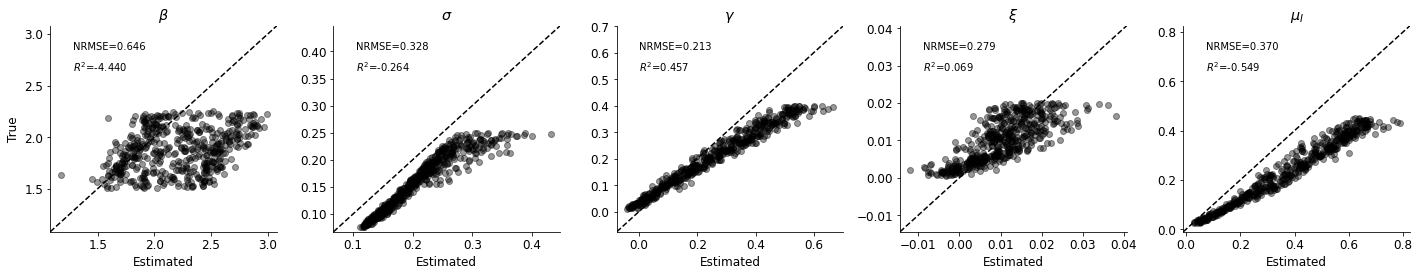

In [17]:
#from utils import misc
true_vs_estimated(model, X_test, params_test, n_samples_posterior, parameter_names, figsize=(20, 4), params_samples_mean=params_samples_mean, show=True, filename=None, font_size=12)

In [18]:
# Select random tseries
idx = np.random.choice(params_samples.shape[1], 1, replace=False)

In [19]:
selected_params_samples = params_samples[:, idx, :].squeeze()
selected_params_test = params_test[idx, :].squeeze()
selected_X_test = X_test[idx, :].squeeze()

In [20]:
print(selected_params_samples.shape)
print(selected_params_test.shape)
print(selected_X_test.shape)

(2000, 5)
(5,)
(150, 7)


<Figure size 432x288 with 0 Axes>

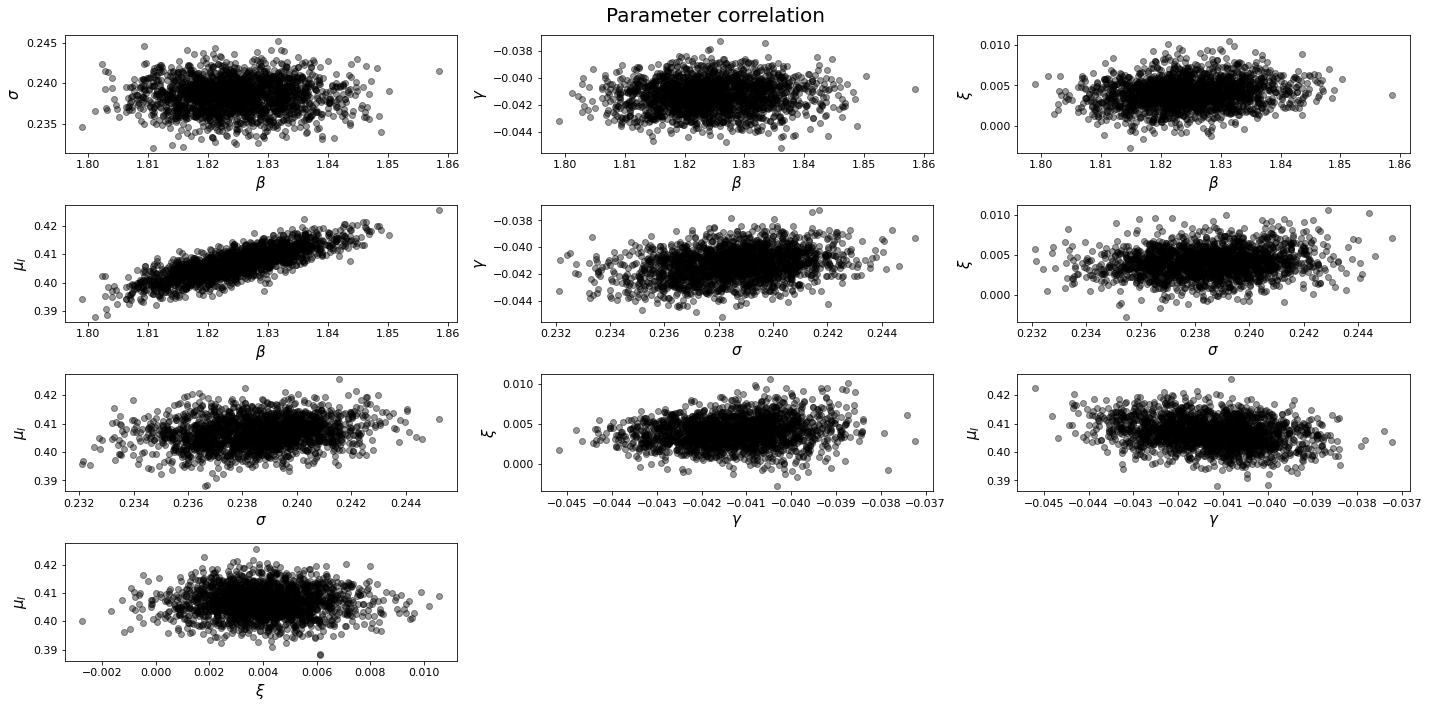

<Figure size 1440x720 with 0 Axes>

In [22]:
plot_parameters_correlation(selected_params_samples, parameter_names)

In [23]:
selected_params_samples_mean = selected_params_samples.mean(axis=0)

In [27]:
# Tseries generated with the mean of the sampled parameters for the selected tseries
data_model = SEIRSModel(initN=initN, initI=1, beta=selected_params_samples_mean[0], sigma=selected_params_samples_mean[1], gamma=selected_params_samples_mean[2], xi=selected_params_samples_mean[3], mu_I=selected_params_samples_mean[4])
data_model.run(T=150)

t = 30.60


True

/Users/davidjackson/AMLProject/seirsplus/seirsplus/models.py:430: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


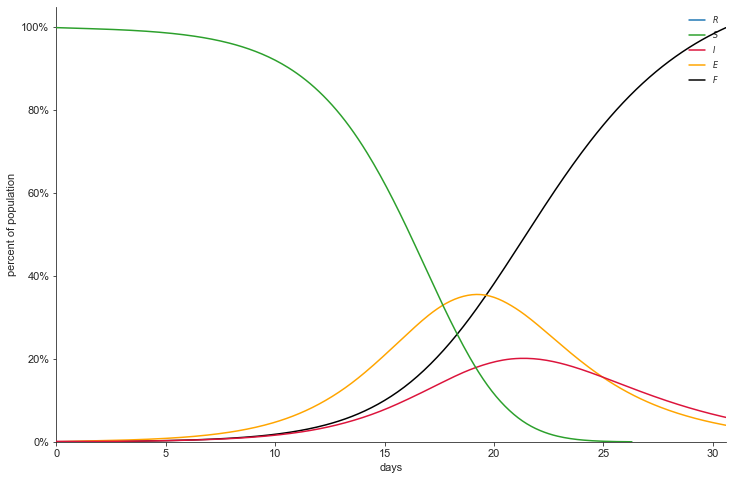

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='days', ylabel='percent of population'>)

In [28]:
data_model.figure_basic()

/Users/davidjackson/AMLProject/seirsplus/seirsplus/models.py:430: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


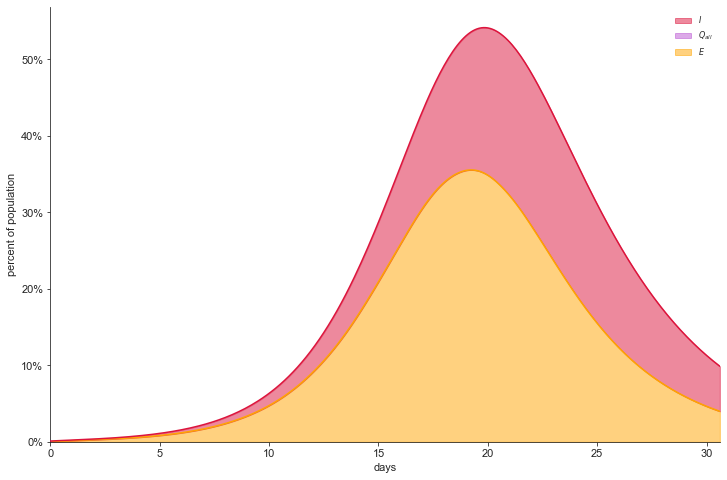

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='days', ylabel='percent of population'>)

In [29]:
data_model.figure_infections()

In [26]:
# Wrapper function to generate n_sample_posterior tseries from the selected tseries
tseries = wrapper_generation(selected_params_samples)

IndexError: index 5 is out of bounds for axis 1 with size 5

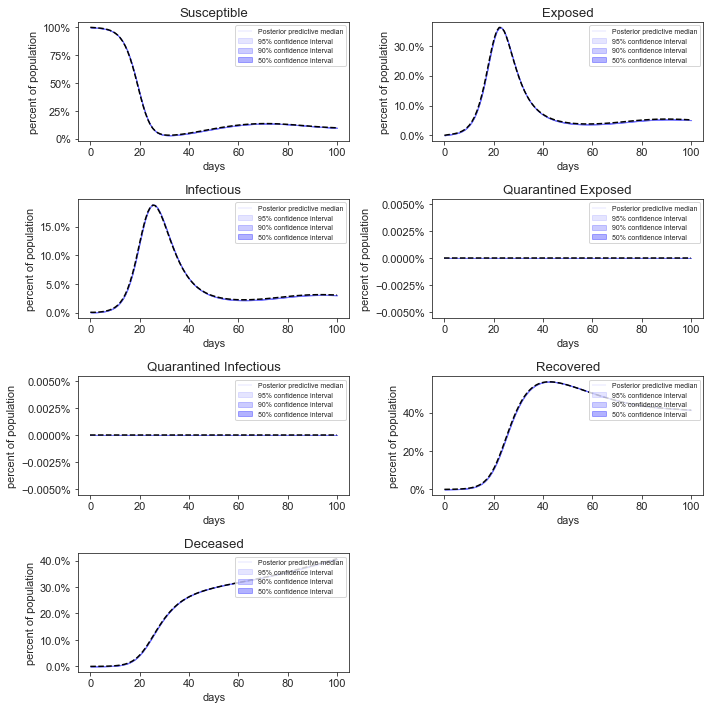

In [20]:
cmap = cm.Blues
labels = ['Susceptible', 'Exposed', 'Infectious', 'Quarantined Exposed', 'Quarantined Infectious','Recovered', 'Deceased']
plot_ppc(tseries, labels, X_test=selected_X_test, confidence_intervals=True, median='Blue')